In [ ]:
#test the geo distance matrix, added in the function files
#weighted cluster method
library('data.table')
library('ggplot2')
library('ggmap')
library('dbscan')
library('dplyr')
library('xts')
#smu
funPath='D:/share/Git/Rprojects/ECA/function.R'

#funPath='D:/Git/Rprojects/ECA/function.R'
source(funPath)

In [222]:
#get clusters
findCluster<-function(dt,eps=0.002,minp=10){
    
    temp1 <- as.matrix(dt[,list(lon,lat)])
    cl <- dbscan(temp1, eps = eps, minPts =minp)
    temp2=data.table(cbind(dt,c=cl$cluster));  
    return(temp2[c>0])
    
}

In [142]:
#extract each trip from each cluster and mmsi
#input:candidate clusters
#output:cluster and duration for each ship in hours
findTrip<-function(dt,eps=6000*2,minp=5){
    
    temp3=dt[,.N,list(c,mmsi)]
    nr=nrow(temp3)#how many ships
    #nr=14
    tt=dt[mmsi<0];tt=tt[,c1:=0][c1<0]
    t0=data.table(mmsi=0,c=0,c1=0,dur=0)[mmsi<0]
    for (i in seq(1:nr)){
    r=temp3[i]
    cship=dt[mmsi==r$mmsi&c==r$c]
    setkey(cship,mmsi,time)
    cship2 <- as.matrix(cship[,list(time)])#get time series
    cl2 <- dbscan(cship2, eps = eps, minPts =minp)
    cship3=data.table(cbind(cship,c1=cl2$cluster));
    tt=rbind(tt,cship3)
    #if(nrow(cship3[c1>0])>0){
    #    t1=cship3[c1>0,list(dur=(max(.SD$time)-min(.SD$time))/3600),by=list(c,mmsi,c1)]
    #    t0=rbind(t0,t1) 
    #}
    }
    return(tt)

}


In [266]:
#input eps is for dbscan to combine different clusters which actually at the same terminal but seperate by two or more grids
#eps set to be the doubel of the eps used to identify candidates terminals
#minp set to 2 as we only sample one point from each candidate cluster for combination purpose
getFinalCluster<-function(dt,eps=0.002*2,minp=2){
    sampled=dt[,.SD[median(1:.N)],list(glon,glat,c)]# the points produced with medium are representative
    cl=sampled[,.N,list(glon,glat,c)]
    cl=cbind(cl,cid=seq(1:nrow(cl)))#set new cluster ids
    
    sampled1=data.table(left_join(sampled,cl[,list(glon,glat,c,cid)],by=c('glon','glat','c')))
    cls=findCluster(sampled1[,list(c.org=c,glon,glat,lon,lat,cid)],eps,minp)#doubel the eps
    s2=cls[c>0,.N,list(glon,glat,c,c.org,cid)];
    s3=s2[,N,c];
    dt1=data.table(left_join(dt,cl[,list(glon,glat,c,cid)],by=c('glon','glat','c')))
    dt1=dt1[,fcid:=cid]#add final cluster identification
    #replace the cluster id at the same terminal
   
    for (i in unique(s2$c)){
        cids=s2[c==i]$cid
        dt1=dt1[fcid%in%cids,fcid:=min(cids)]  
    }
    return(dt1)    
}

In [ ]:
file1='D:/share/AIS/ECAContainerSpeed10/3438807_3.csv'
file2='D:/share/AIS/ECAContainerSpeed10/5000000_1.csv'
file3='D:/share/AIS/ECAContainerSpeed10/5000000_2.csv'
file4='D:/share/AIS/globalContainer2015/201510.txt'

In [ ]:
d1=fread(file1)[status==5&sog==0][,list(mmsi,time,status,sog,lon,lat)];dim(d1)
d2=fread(file2)[status==5&sog==0][,list(mmsi,time,status,sog,lon,lat)];dim(d2)
d3=fread(file3)[status==5&sog==0][,list(mmsi,time,status,sog,lon,lat)];dim(d3)

In [ ]:
d4=rbind(d1,d2,d3);head(d4);setkey(d4,mmsi,time);dim(d4)

In [ ]:
#sample 
tmp=d4[,atime:=align.time(as.POSIXct(time,origin='1970-01-01'),60*20)];dim(tmp);head(tmp);nrow(tmp[,.N,list(mmsi,atime)])
d5=tmp[,.SD[1],list(mmsi,atime)];dim(d5);head(d5)

In [ ]:
#set grids
scale=1
d5=d5[,glon:=floor(lon*scale)/scale]
d5=d5[,glat:=floor(lat*scale)/scale]
d6=d5[,.N,list(glon,glat)]
setorder(d6,-N)
head(d6)

In [ ]:
#combine results of all grids
eps=0.002
minp=10
candidates=d5[mmsi<0];
candidates=candidates[,c:=0]
candidates=candidates[,c1:=0][c<0]
for (i in seq(1:nrow(d6))){
    print(i)
    r=d6[i]    
    temp=d5[glon==r$glon&glat==r$glat]
    temp2=findCluster(temp,eps,minp)
    t0=findTrip(temp2)
    candidates=rbind(candidates,t0)
}

In [272]:
head(candidates);dim(candidates[,.N,c]);dim(candidates)

mmsi,atime,time,status,sog,lon,lat,glon,glat,c,c1
209075000,2014-01-11 11:40:00,1389411011,5,0,121.5825,31.37385,121,31,1,1
209075000,2014-01-11 12:00:00,1389411717,5,0,121.5824,31.37392,121,31,1,1
209075000,2014-01-11 12:20:00,1389412811,5,0,121.5824,31.37392,121,31,1,1
209075000,2014-01-11 12:40:00,1389414061,5,0,121.5826,31.37383,121,31,1,1
209075000,2014-01-11 13:00:00,1389415339,5,0,121.5825,31.37388,121,31,1,1
209075000,2014-01-11 13:20:00,1389416678,5,0,121.5825,31.37390,121,31,1,1


[1] 63  2

[1] 682754     11

In [273]:
#number of trips with duration
t1=candidates[c>0&c1>0,list(dur=(max(.SD$time)-min(.SD$time))/3600),by=list(glon,glat,c,mmsi,c1)]
head(t1);dim(t1)

glon,glat,c,mmsi,c1,dur
121,31,1,209075000,1,9.206389
121,31,1,209075000,2,10.880833
121,31,1,209075000,3,10.285278
121,31,1,209075000,4,5.119444
121,31,1,209075000,5,20.226944
121,31,1,209075000,6,13.939722


[1] 14881     6

In [277]:
#head(t0)
t2=t1[c>0,list(uniques=length(unique(.SD$mmsi)),mean=mean(dur),median=median(dur)),list(glon,glat,c)]
t3=t1[c>0,list(uniques=length(unique(.SD$mmsi)),mean=mean(dur),median=median(dur)),list(glon,glat,c)][mean<20]
t4=t1[c>0,list(uniques=length(unique(.SD$mmsi)),mean=mean(dur),median=median(dur)),list(glon,glat,c)][mean<20][uniques>5]

t4

[1]  0 10

glon,glat,c,uniques,mean,median
121,31,1,432,13.605097,11.996389
121,31,2,443,12.589117,11.499167
121,31,18,12,15.049390,11.802222
121,31,34,16,14.552035,12.053611
122,29,1,480,13.020960,12.019861
122,29,2,200,9.288862,8.397083
122,30,1,813,14.308755,12.998889
121,29,1,236,11.222461,9.300556
121,29,2,228,9.161916,8.601389
121,29,3,321,11.095633,10.199306


In [276]:
head(candidates);dim(candidates)
selected=data.table(inner_join(candidates,t4[,list(glon,glat,c)],by=c('glon','glat','c')))
dim(selected);head(selected);selected[,.N,list(glon,glat,c)]

mmsi,atime,time,status,sog,lon,lat,glon,glat,c,c1
209075000,2014-01-11 11:40:00,1389411011,5,0,121.5825,31.37385,121,31,1,1
209075000,2014-01-11 12:00:00,1389411717,5,0,121.5824,31.37392,121,31,1,1
209075000,2014-01-11 12:20:00,1389412811,5,0,121.5824,31.37392,121,31,1,1
209075000,2014-01-11 12:40:00,1389414061,5,0,121.5826,31.37383,121,31,1,1
209075000,2014-01-11 13:00:00,1389415339,5,0,121.5825,31.37388,121,31,1,1
209075000,2014-01-11 13:20:00,1389416678,5,0,121.5825,31.37390,121,31,1,1


[1] 682754     11

[1] 470526     11

mmsi,atime,time,status,sog,lon,lat,glon,glat,c,c1
209075000,2014-01-11 11:40:00,1389411011,5,0,121.5825,31.37385,121,31,1,1
209075000,2014-01-11 12:00:00,1389411717,5,0,121.5824,31.37392,121,31,1,1
209075000,2014-01-11 12:20:00,1389412811,5,0,121.5824,31.37392,121,31,1,1
209075000,2014-01-11 12:40:00,1389414061,5,0,121.5826,31.37383,121,31,1,1
209075000,2014-01-11 13:00:00,1389415339,5,0,121.5825,31.37388,121,31,1,1
209075000,2014-01-11 13:20:00,1389416678,5,0,121.5825,31.37390,121,31,1,1


glon,glat,c,N
121,31,1,96355
121,31,2,121082
121,31,18,1636
121,31,34,6156
122,29,1,57968
122,29,2,17563
122,30,1,90583
121,29,1,20141
121,29,2,20172
121,29,3,30167


[1] 471

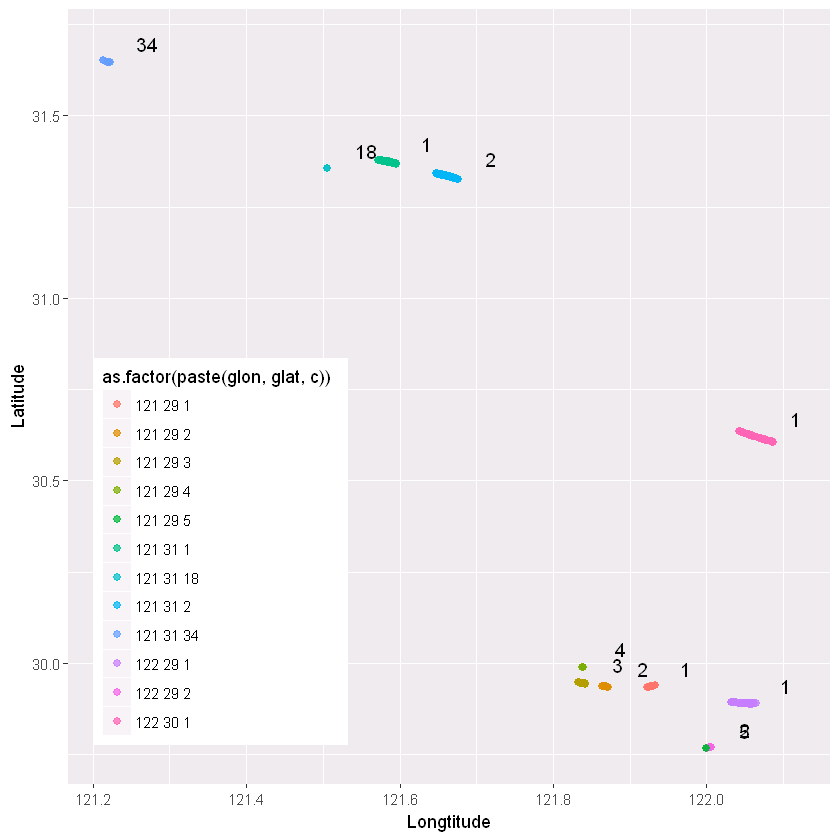

In [185]:
zoomSize=8
temp=sampled;nrow(temp)

centerX=0.5*(max(temp$lon)+min(temp$lon))
centerY=0.5*(max(temp$lat)+min(temp$lat))
#p<-ggmap(get_map(location=c(centerX,centerY),zoom=zoomSize,source='google',maptype = 'satellite'))
p=ggplot()
p=p+geom_point(data=temp,aes(x=lon,y=lat,col=as.factor(paste(glon,glat,c))),size=2,alpha=0.75)
p=p+geom_text(data=temp[,.SD[1],list(glon,glat,c)],nudge_x = 0.05,nudge_y = 0.05,aes(x=lon,y=lat,label=c),color='black',size=4)
p=p+labs(x="Longtitude",y="Latitude")+theme(legend.position=c(0.2,0.3))
#p
#hulls=temp[chull(temp[,list(lon,lat)]),]
#p=p+geom_point(data = hulls, aes(x = lon, y = lat),size=1,col='yellow') 
#p=p+geom_polygon(data = hulls, aes(x = lon, y = lat),fill='yellow',alpha = 0.4)
p

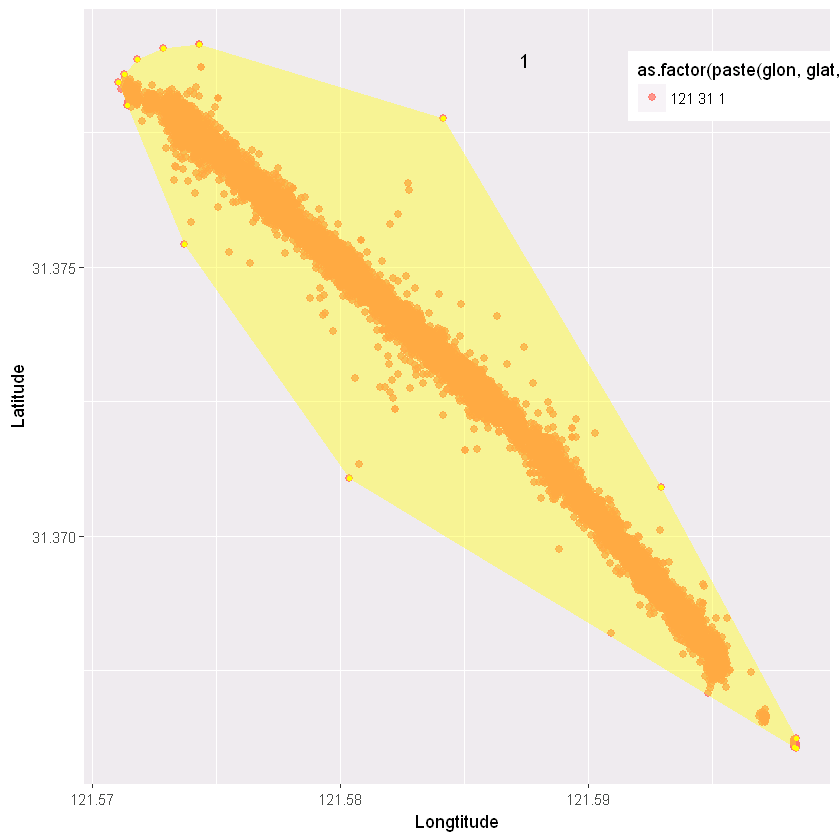

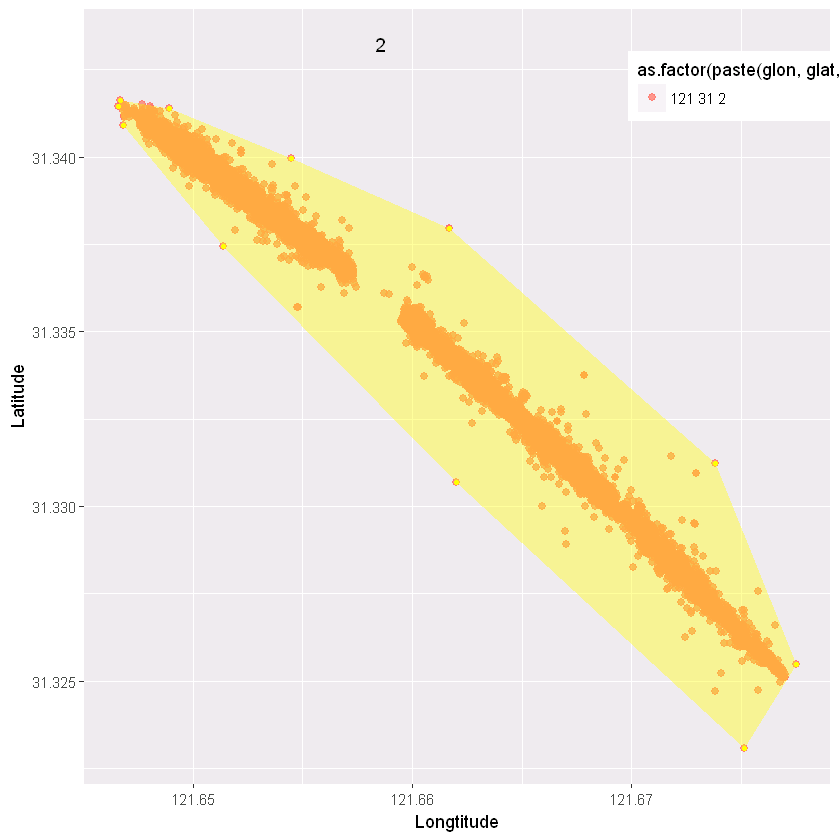

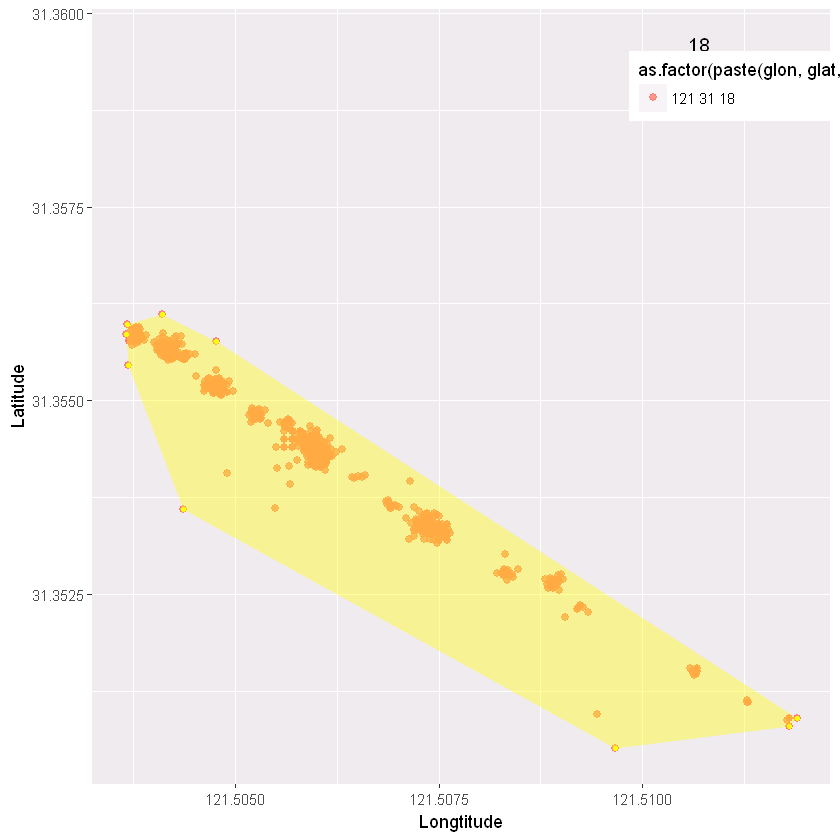

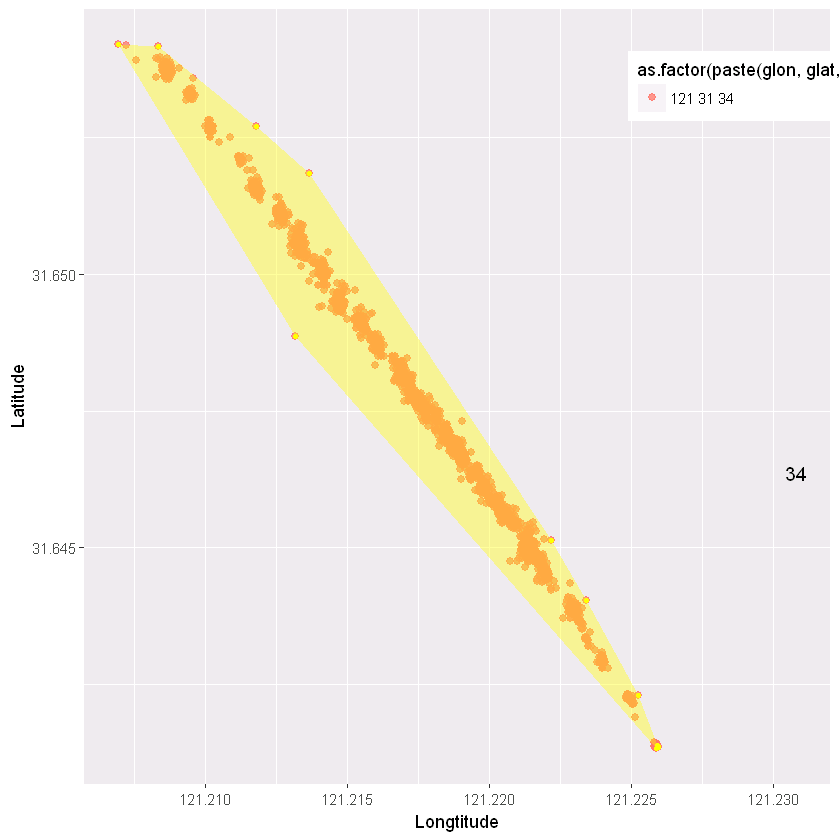

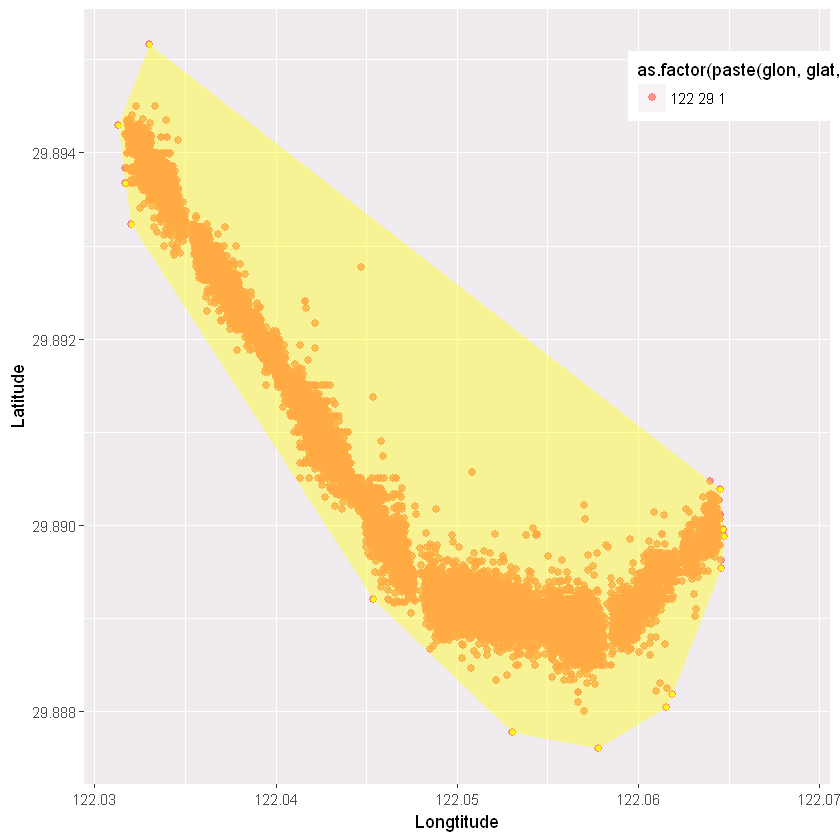

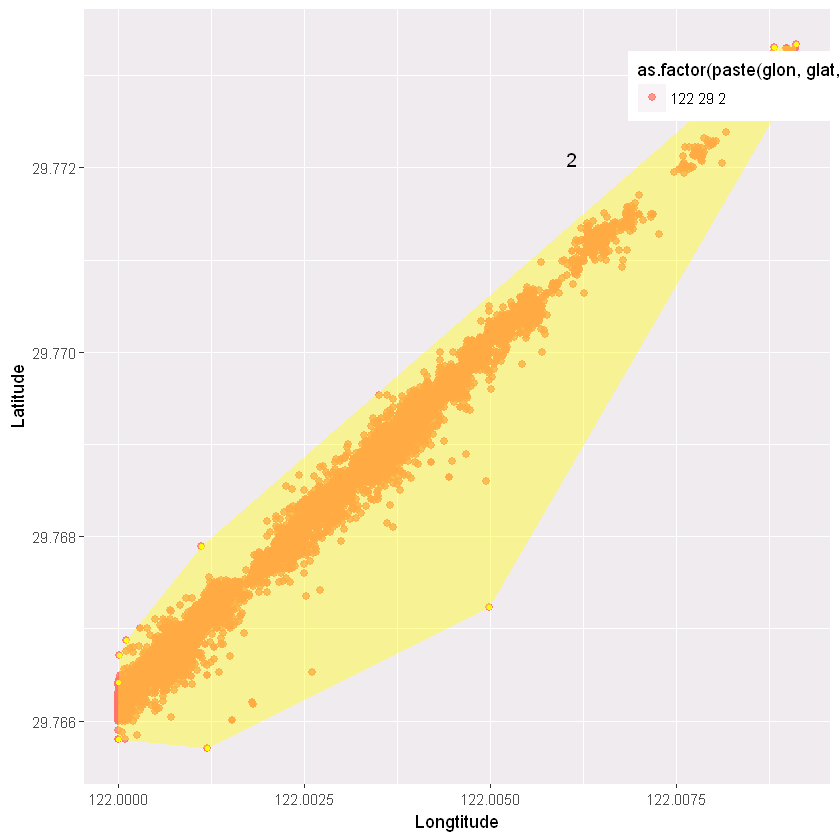

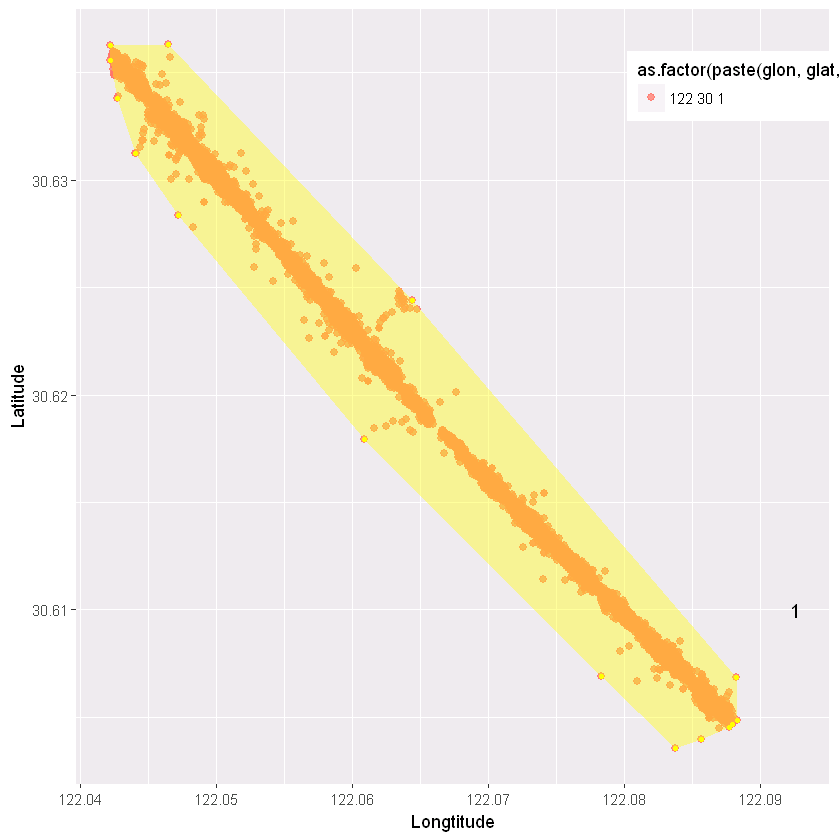

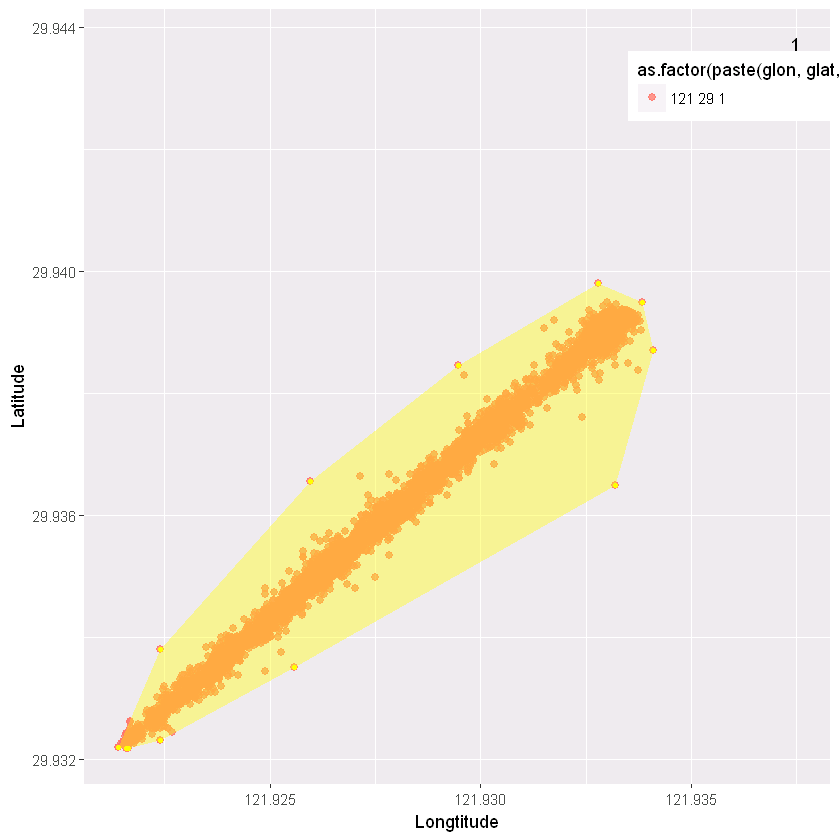

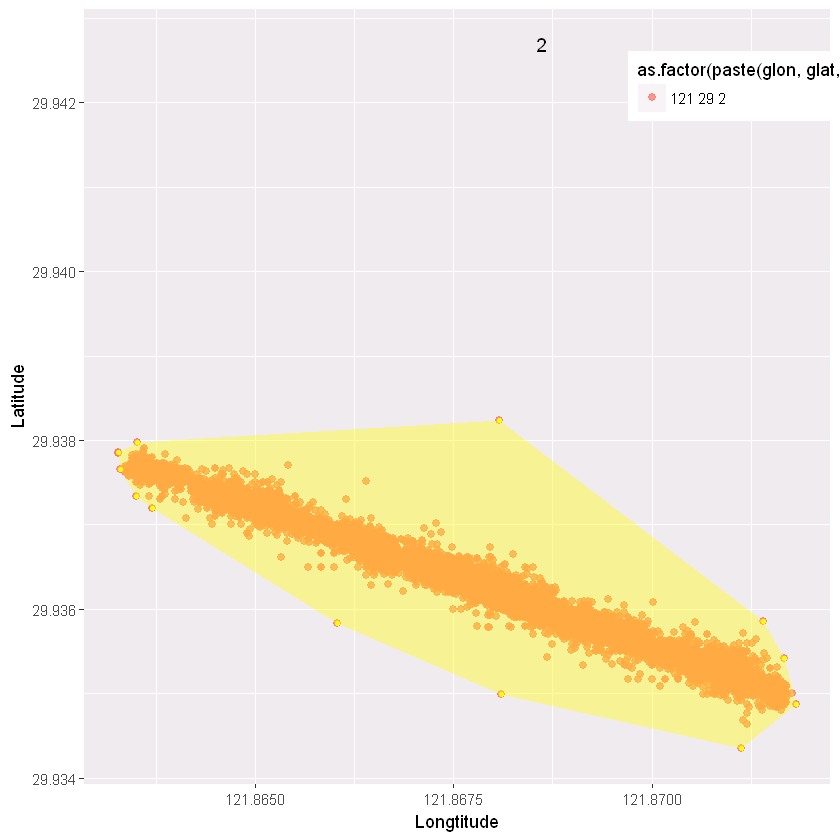

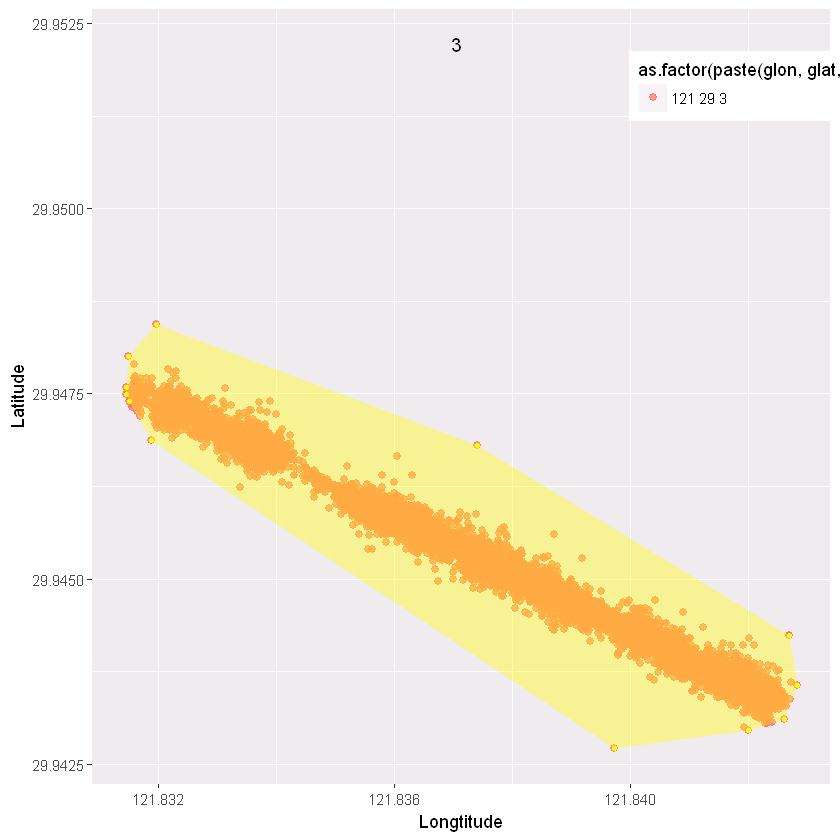

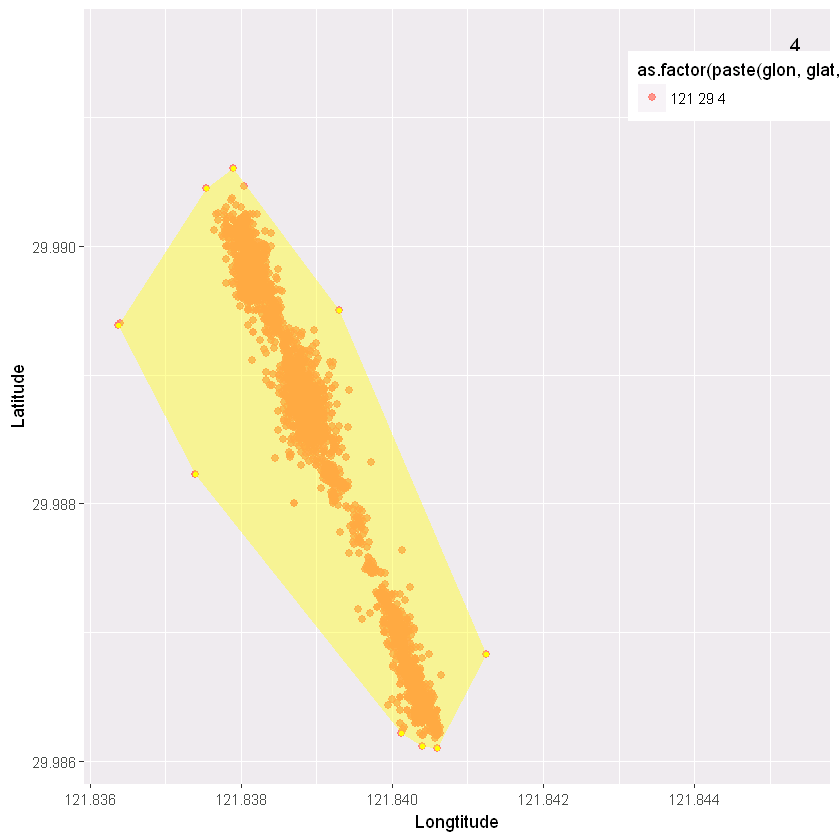

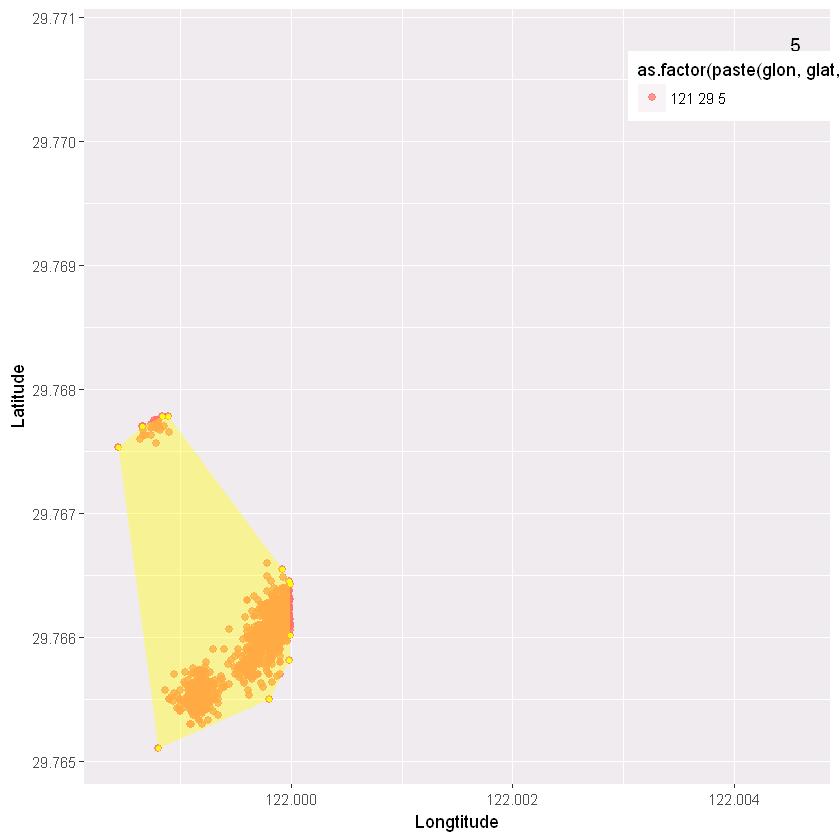

In [189]:
tc=selected[,.N,list(glon,glat,c)]

for (i in seq(1:nrow(tc))){
    #zoomSize=8
    r=tc[i]
    temp=selected[glon==r$glon&glat==r$glat&c==r$c];nrow(temp)
    #centerX=0.5*(max(temp$lon)+min(temp$lon))
    #centerY=0.5*(max(temp$lat)+min(temp$lat))
    #p<-ggmap(get_map(location=c(centerX,centerY),zoom=zoomSize,source='google',maptype = 'satellite'))
    p=ggplot()
    p=p+geom_point(data=temp,aes(x=lon,y=lat,col=as.factor(paste(glon,glat,c))),size=2,alpha=0.75)
    p=p+geom_text(data=temp[,.SD[1],list(glon,glat,c)],nudge_x = 0.005,nudge_y = 0.005,aes(x=lon,y=lat,label=c),color='black',size=4)
    p=p+labs(x="Longtitude",y="Latitude")+theme(legend.position=c(0.9,0.9))
    #p
    hulls=temp[chull(temp[,list(lon,lat)]),]
    p=p+geom_point(data = hulls, aes(x = lon, y = lat),size=1,col='yellow') 
    p=p+geom_polygon(data = hulls, aes(x = lon, y = lat),fill='yellow',alpha = 0.4)
    plot(p) 
    
}

In [278]:
#sample one points for each candidate cluster
#tempsample=selected[,.SD[1:2],list(glon,glat,c)];head(tempsample)
rs=getFinalCluster(selected,0.004,2)#just use the selected replace the tempsample, here is only for test purpose
dim(rs);head(rs)
#head(sampled);dim(sampled)

glon,glat,c,mmsi,atime,time,status,sog,lon,lat,c1
121,31,1,209075000,2014-01-11 11:40:00,1389411011,5,0,121.5825,31.37385,1
121,31,1,209075000,2014-01-11 12:00:00,1389411717,5,0,121.5824,31.37392,1
121,31,2,209127000,2014-01-12 23:00:00,1389538627,5,0,121.6536,31.33823,1
121,31,2,209127000,2014-01-12 23:20:00,1389538807,5,0,121.6536,31.33824,1
121,31,18,248560000,2014-09-28 16:40:00,1411892812,5,0,121.5057,31.35460,1
121,31,18,248560000,2014-09-28 17:00:00,1411893792,5,0,121.5057,31.35450,1


[1] 470526     13

mmsi,atime,time,status,sog,lon,lat,glon,glat,c,c1,cid,fcid
209075000,2014-01-11 11:40:00,1389411011,5,0,121.5825,31.37385,121,31,1,1,1,1
209075000,2014-01-11 12:00:00,1389411717,5,0,121.5824,31.37392,121,31,1,1,1,1
209075000,2014-01-11 12:20:00,1389412811,5,0,121.5824,31.37392,121,31,1,1,1,1
209075000,2014-01-11 12:40:00,1389414061,5,0,121.5826,31.37383,121,31,1,1,1,1
209075000,2014-01-11 13:00:00,1389415339,5,0,121.5825,31.37388,121,31,1,1,1,1
209075000,2014-01-11 13:20:00,1389416678,5,0,121.5825,31.37390,121,31,1,1,1,1


[1] 11

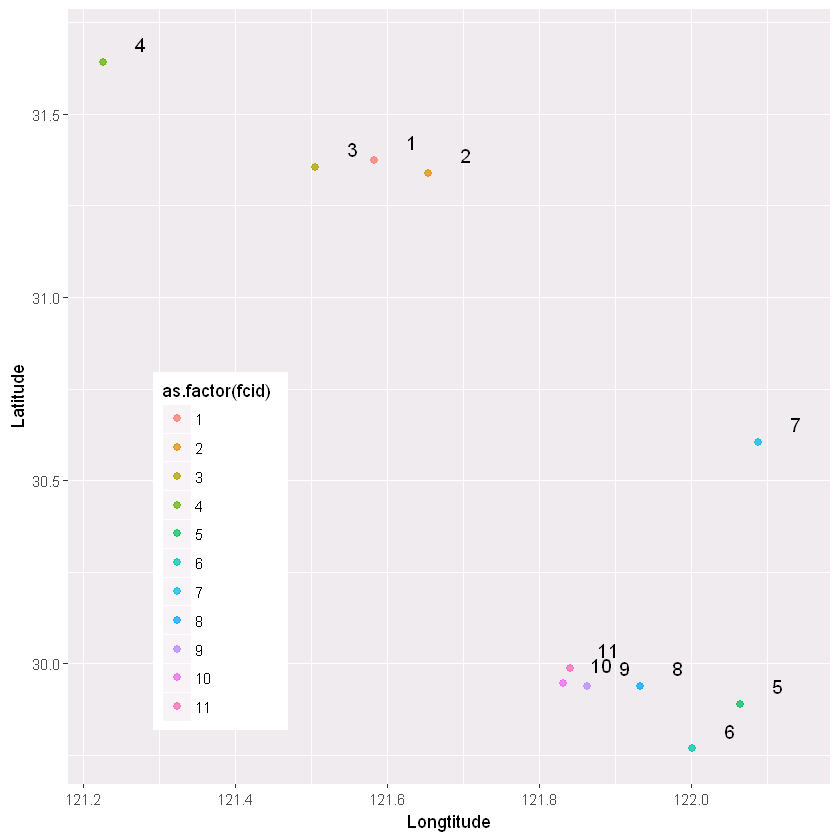

In [279]:
zoomSize=8
temp=rs[,.SD[1],fcid];nrow(temp)

centerX=0.5*(max(temp$lon)+min(temp$lon))
centerY=0.5*(max(temp$lat)+min(temp$lat))
#p<-ggmap(get_map(location=c(centerX,centerY),zoom=zoomSize,source='google',maptype = 'satellite'))
p=ggplot()
p=p+geom_point(data=temp,aes(x=lon,y=lat,col=as.factor(fcid)),size=2,alpha=0.75)
p=p+geom_text(data=temp[,.SD[1],list(fcid)],nudge_x = 0.05,nudge_y = 0.05,aes(x=lon,y=lat,label=fcid),color='black',size=4)
p=p+labs(x="Longtitude",y="Latitude")+theme(legend.position=c(0.2,0.3))
#p
#hulls=temp[chull(temp[,list(lon,lat)]),]
#p=p+geom_point(data = hulls, aes(x = lon, y = lat),size=1,col='yellow') 
#p=p+geom_polygon(data = hulls, aes(x = lon, y = lat),fill='yellow',alpha = 0.4)
p

In [280]:
set.seed(2000)
sampled=rs[,sample_frac(.SD,0.01),list(glon,glat,c)]
head(sampled);dim(sampled)
write.csv(sampled,'d:/share/terminals.csv')

glon,glat,c,mmsi,atime,time,status,sog,lon,lat,c1,cid,fcid
121,31,1,309806000,2014-09-25 15:00:00,1411627223,5,0,121.5863,31.37250,18,1,1
121,31,1,477503000,2014-05-23 02:40:00,1400783502,5,0,121.5715,31.37820,16,1,1
121,31,1,355856000,2014-03-04 12:40:00,1393906928,5,0,121.5923,31.36917,2,1,1
121,31,1,356405000,2014-07-16 22:00:00,1405518075,5,0,121.5799,31.37511,5,1,1
121,31,1,564238000,2014-09-13 21:40:00,1410614410,5,0,121.5904,31.37030,5,1,1
121,31,1,368684000,2014-11-25 12:00:00,1416886922,5,0,121.5742,31.37747,1,1,1


[1] 4707   13